### Semantic Segmentation

1.1 Dataset: Use the oxford_iiit_pet dataset from Keras or PyTorch.

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the Oxford-IIIT Pet Dataset
dataset, info = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=False)

train_dataset = dataset['train']
test_dataset = dataset['test']

# Print dataset info
print(info)
print(info.features['species'].names)

# Display one sample image and label to understand the data format
for sample in train_dataset.take(1):
    img, breed_label = sample['image'], sample['species'],
    img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize image values
    print(f"Image shape: {img.shape}")
    print(f"Breed label: {breed_label}")

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    spl

1.2 Starter Code for Dataset Loading:

Split the dataset into training and testing subsets, then split the training set into a training and validation subsets.


In [2]:
import tensorflow as tf

# Data Preprocessing Function – Binary Label Conversion, Resizing, and Mask Preparation
def prepare_data(sample_data):
    # Extract image and segmentation information
    img = sample_data['image']
    seg_mask = sample_data['segmentation_mask']

    # Resize the image and segmentation mask
    img = tf.image.resize(img, [128, 128])
    seg_mask = tf.image.resize(seg_mask, [128, 128], method='nearest')

    # Normalize image to [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Binarize segmentation mask and cast to uint8
    seg_mask = tf.where(seg_mask == 1, 1, 0)
    seg_mask = tf.cast(seg_mask, tf.uint8)
    img = tf.cast(img, tf.uint8)

    # Extract additional label
    label = sample_data['species']

    return img, seg_mask  # Optionally return as img, {'mask': seg_mask, 'label': label}


# Define train-validation split sizes
train_data_size = int(0.8 * info.splits['train'].num_examples)
validation_data_size = info.splits['train'].num_examples - train_data_size

print(f"Train Data Size: {train_data_size}")
print(f"Validation Data Size: {validation_data_size}")

# Shuffle the full training dataset and split it into training and validation sets
ShuffleFull_train_dataset = train_dataset.shuffle(buffer_size=1000)

# Split dataset into training and validation sets
train_dataset = ShuffleFull_train_dataset.take(train_data_size)
validation_dataset = ShuffleFull_train_dataset.skip(train_data_size)

# Apply the preprocessing function to each dataset
train_dataset = train_dataset.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch datasets for performance
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

Train Data Size: 2944
Validation Data Size: 736


1.3 Training a Simple CNN for Semantic Segmentation (without skip connections):

• Train a simple convolutional neural network for supervised semantic segmentation (without skip connections).

• Plot the training and validation loss and evaluation metric as a function of epochs.

• Visualize some inference results.'

• Provide quantitative training, validation, and testing results.

1.4 Training a CNN for Semantic Segmentation with Skip Connections (U-Net):

• Train a CNN for semantic segmentation with skip connections (as ni U-Net).

• Evaluate and visualize the results as before.


In [3]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam

def CNN_modelBasic(img_size, num_classes):
    inputs = Input(shape=img_size)

    # Encoder
    x = layers.Conv2D(32, 3, strides=2, activation='relu', padding="same")(inputs)
    x = layers.Conv2D(32, 3, activation='relu', padding="same")(x)

    x = layers.Conv2D(64, 3, strides=2, activation='relu', padding="same")(x)
    x = layers.Conv2D(64, 3, activation='relu', padding="same")(x)

    x = layers.Conv2D(128, 3, strides=2, activation='relu', padding="same")(x)
    x = layers.Conv2D(128, 3, activation='relu', padding="same")(x)

    # Decoder
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding="same")(x)

    x = layers.Conv2DTranspose(64, 3, activation='relu', padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding="same")(x)

    x = layers.Conv2DTranspose(32, 3, activation='relu', padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding="same")(x)

    # Output layer with softmax for multi-class segmentation
    outputs = layers.Conv2D(num_classes, 3, activation='softmax',padding="same")(x)

    model = models.Model(inputs, outputs)
    return model

# Create and compile the model for multi-class segmentation
CNN_modelBasic = CNN_modelBasic((128, 128, 3), num_classes=2)
CNN_modelBasic.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
CNN_modelBasic.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 2)         │             578 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 721,186 (2.75 MB)

 Trainable params: 721,186 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 312ms/step - accuracy: 0.6750 - loss: 0.5814 - val_accuracy: 0.7388 - val_loss: 0.4771
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.7828 - loss: 0.4635 - val_accuracy: 0.8002 - val_loss: 0.4532
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 195ms/step - accuracy: 0.7977 - loss: 0.4519 - val_accuracy: 0.8133 - val_loss: 0.4254
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 222ms/step - accuracy: 0.8172 - loss: 0.4243 - val_accuracy: 0.8240 - val_loss: 0.4131
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.8284 - loss: 0.4077 - val_accuracy: 0.8438 - val_loss: 0.3770
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - accuracy: 0.8479 - loss: 0.3685 - val_accuracy: 0.8518 - val_loss: 0.3378
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.8558 - loss: 0.3334 - val_accuracy: 0.8588 - val_loss: 0.3205
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - accuracy: 0.8683 - loss: 0.3065 - val_accu

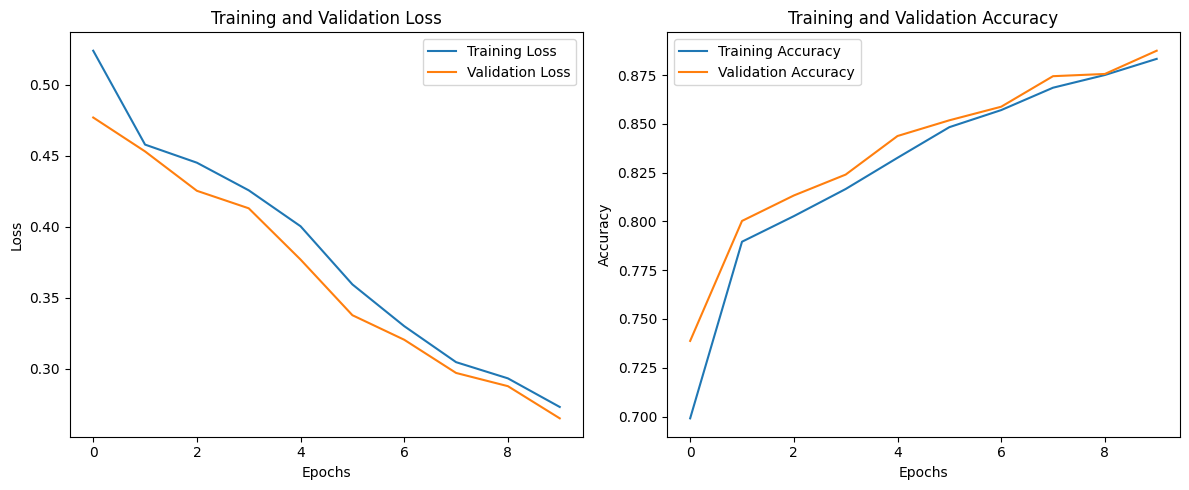

In [4]:
    # Train the model
    history = CNN_modelBasic.fit(
        train_dataset,
        epochs=10,
        validation_data=validation_dataset,
    )

    # Plotting training and validation loss and accuracy for analysis
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

In [5]:
# Function to evaluate and display quantitative results for train, validation, and test datasets
def evaluate_quantitative_results(model, train_data, val_data, test_data):
    # Evaluate on the training data
    train_loss, train_accuracy = model.evaluate(train_data, verbose=0)

    # Evaluate on the validation data
    val_loss, val_accuracy = model.evaluate(val_data, verbose=0)

    # Evaluate on the test data
    test_loss, test_accuracy = model.evaluate(test_data, verbose=0)

    # Display the quantitative results
    print("\nQuantitative Results:")
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Evaluate the model on training, validation, and test datasets
evaluate_quantitative_results(CNN_modelBasic, train_dataset, validation_dataset, test_dataset)


Quantitative Results:
Training Loss: 0.2621, Training Accuracy: 0.8892
Validation Loss: 0.2551, Validation Accuracy: 0.8920
Test Loss: 0.2781, Test Accuracy: 0.8820


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Shape of predicted class masks: (32, 128, 128, 1)
Shape of input images: (32, 128, 128, 3)
Shape of actual masks: (32, 128, 128, 1)


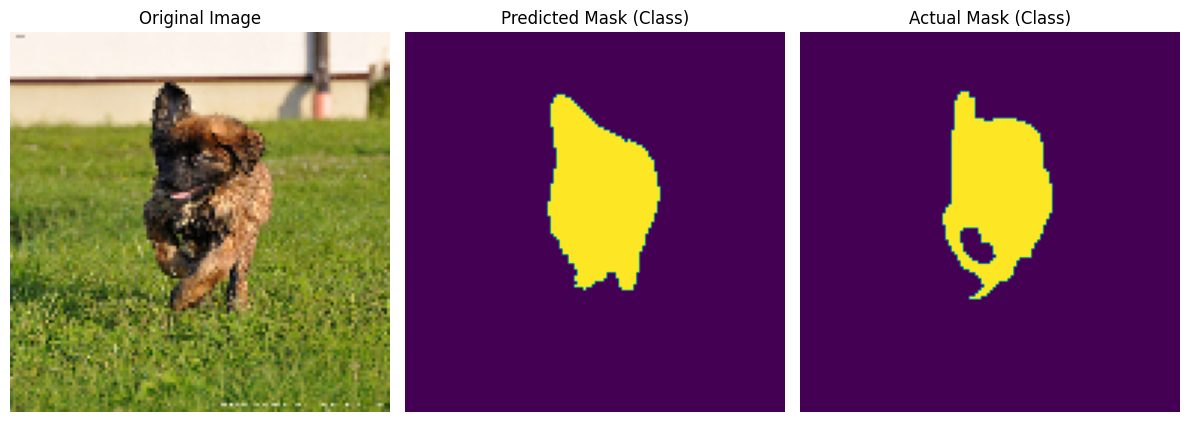

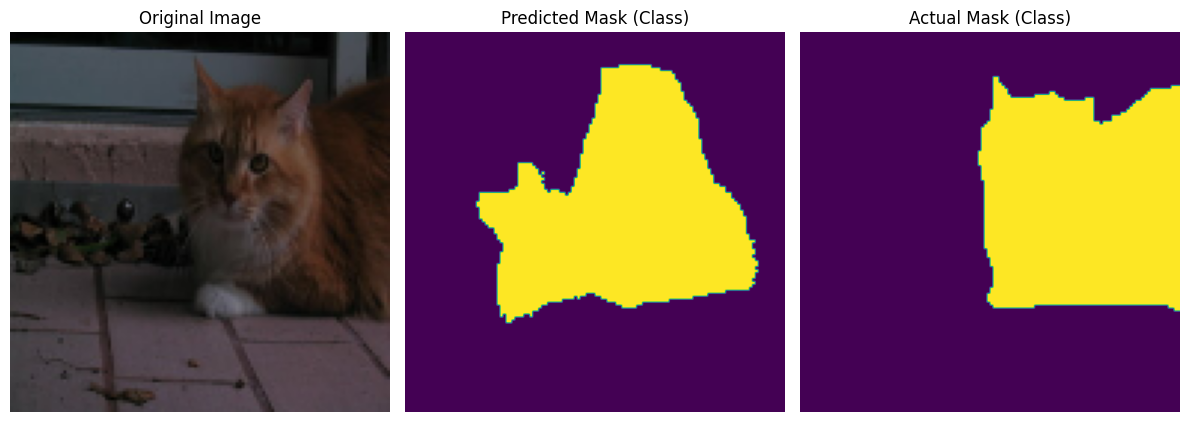

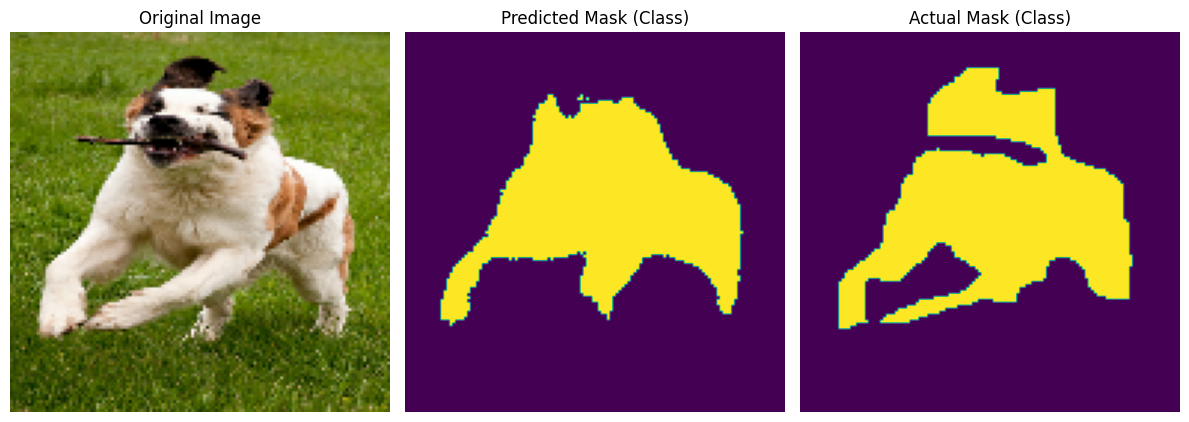

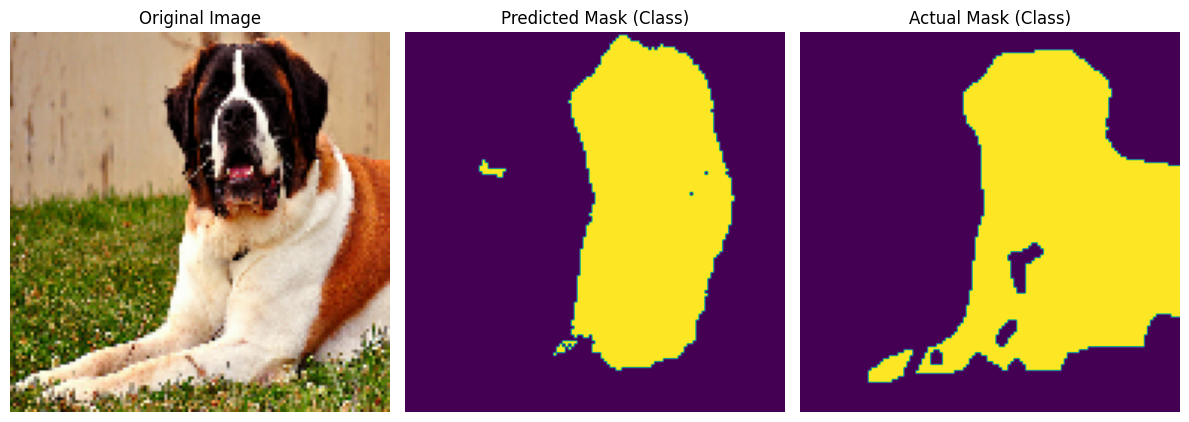

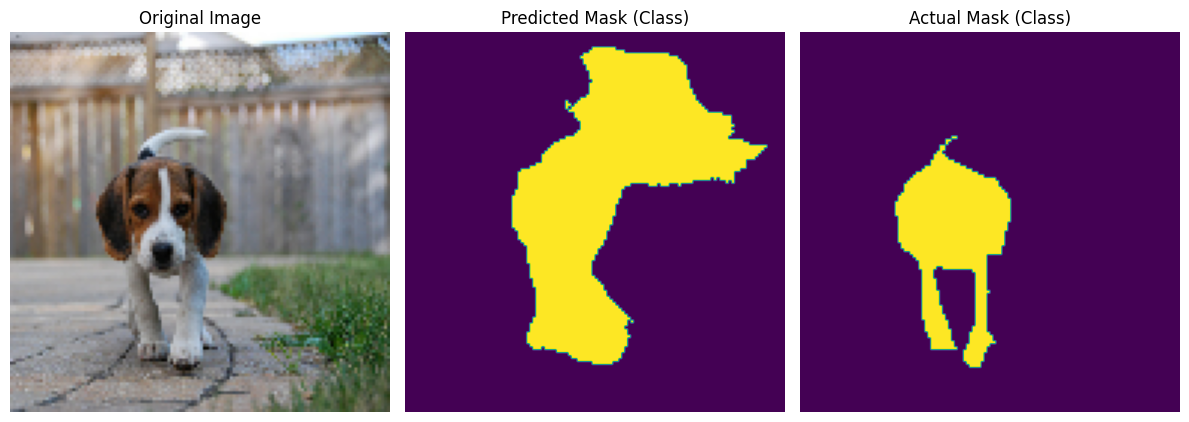

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def MaskGeneration(model, dataset_sample):
    # Get a single batch of images and masks from the dataset
    for images_batch, masks_batch in dataset_sample.take(1):
        # Predict masks for the batch of images
        mask_predictions = model.predict(images_batch)

        # Use np.argmax to select the most likely class for each pixel
        class_masks = np.argmax(mask_predictions, axis=-1)

        # Expand dimensions for visualization purposes
        class_masks = np.expand_dims(class_masks, axis=-1)

        return class_masks, images_batch, masks_batch

# Unified function to display original images, predicted masks, and actual masks

def visualize_predictions(model, dataset_sample, max_images=5):
    # Generate the predicted multi-class masks
    class_masks, input_images, true_masks = MaskGeneration(model, dataset_sample)

    # Print shapes of arrays for verification
    print("Shape of predicted class masks:", class_masks.shape)
    print("Shape of input images:", input_images.shape)
    print("Shape of actual masks:", true_masks.shape)

    # Limit the number of images to display to avoid exceeding subplot limits
    num_images = min(max_images, len(input_images))

    # Display images, predicted masks, and actual masks up to num_images
    for i in range(num_images):
        plt.figure(figsize=(12, 5))

        # Display the original input image
        plt.subplot(1, 3, 1)
        plt.imshow(input_images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title("Original Image")

        # Display the predicted class mask
        plt.subplot(1, 3, 2)
        plt.imshow(class_masks[i, :, :, 0], cmap='viridis')
        plt.axis('off')
        plt.title("Predicted Mask (Class)")

        # Display the actual ground truth mask
        plt.subplot(1, 3, 3)
        plt.imshow(true_masks[i, :, :, 0], cmap='viridis')
        plt.axis('off')
        plt.title("Actual Mask (Class)")

        # Adjust layout and show the plot
        plt.tight_layout()
        plt.show()

# Call the function with a limited number of images to avoid subplot errors
visualize_predictions(CNN_modelBasic, test_dataset, max_images=5)

In [3]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define the U-Net model with skip connections
def UNET_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder with Skip Connections
    up6 = layers.Conv2DTranspose(512, 3, strides=(2, 2), padding='same')(conv5)
    merge6 = layers.concatenate([up6, conv4])
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, 3, strides=(2, 2), padding='same')(conv6)
    merge7 = layers.concatenate([up7, conv3])
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, 3, strides=(2, 2), padding='same')(conv7)
    merge8 = layers.concatenate([up8, conv2])
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, 3, strides=(2, 2), padding='same')(conv8)
    merge9 = layers.concatenate([up9, conv1])
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer with softmax for multi-class segmentation
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = models.Model(inputs, outputs)
    return model

# Instantiate the U-Net model with num_classes set to 3
num_classes = 2
unet_model = UNET_model((128, 128, 3), num_classes)
unet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      4,719,104 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 34,513,410 (131.66 MB)

 Trainable params: 34,513,410 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 131s 715ms/step - accuracy: 0.6313 - loss: 1.9999 - val_accuracy: 0.7062 - val_loss: 0.5603
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 670ms/step - accuracy: 0.7043 - loss: 0.5524 - val_accuracy: 0.6303 - val_loss: 0.7383
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 668ms/step - accuracy: 0.7133 - loss: 0.5524 - val_accuracy: 0.8014 - val_loss: 0.4293
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 74s 568ms/step - accuracy: 0.7975 - loss: 0.4372 - val_accuracy: 0.8078 - val_loss: 0.4137
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 54s 565ms/step - accuracy: 0.8057 - loss: 0.4155 - val_accuracy: 0.7983 - val_loss: 0.4283
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 92s 671ms/step - accuracy: 0.8136 - loss: 0.4028 - val_accuracy: 0.8254 - val_loss: 0.3791
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 63s 669ms/step - accuracy: 0.8311 - loss: 0.3753 - val_accuracy: 0.8395 - val_loss: 0.3625
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 73s 570ms/step - accuracy: 0.8493 - loss: 0.3450 - val_acc

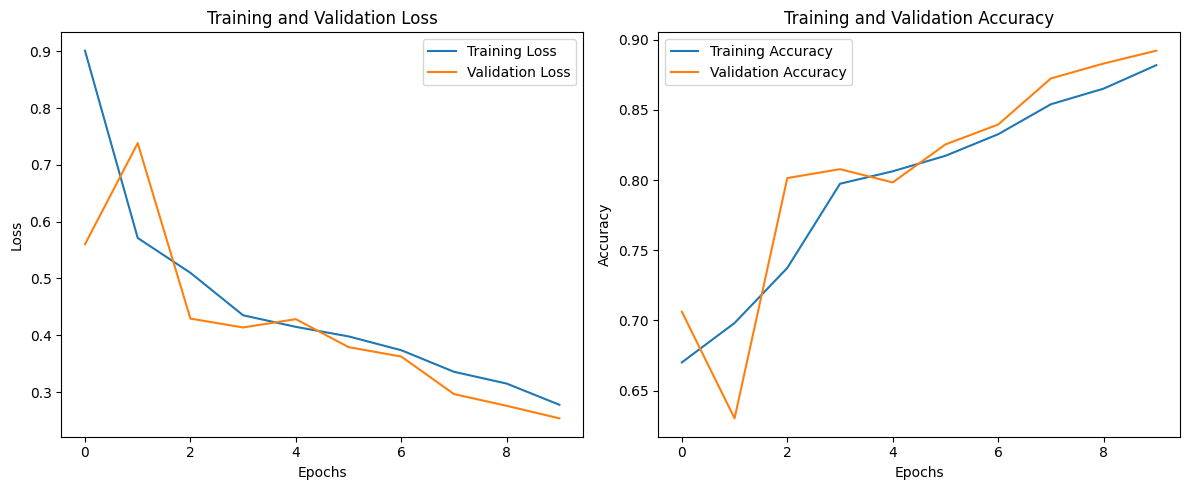

In [4]:
# Train the U-Net model
history = unet_model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
)

# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


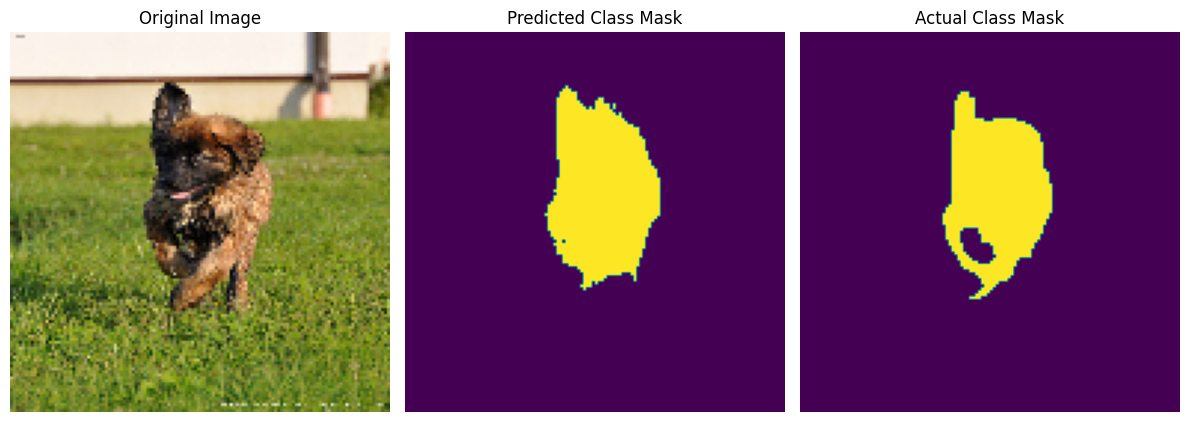

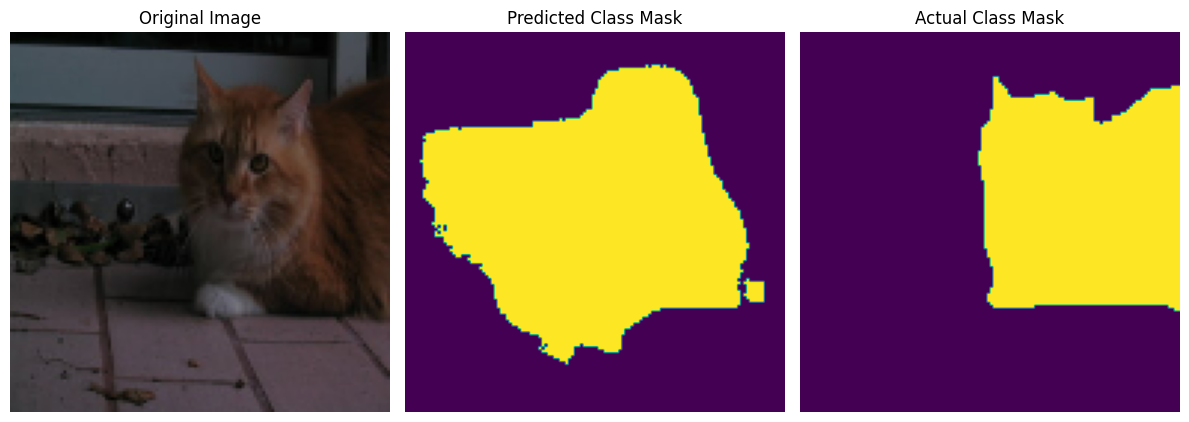

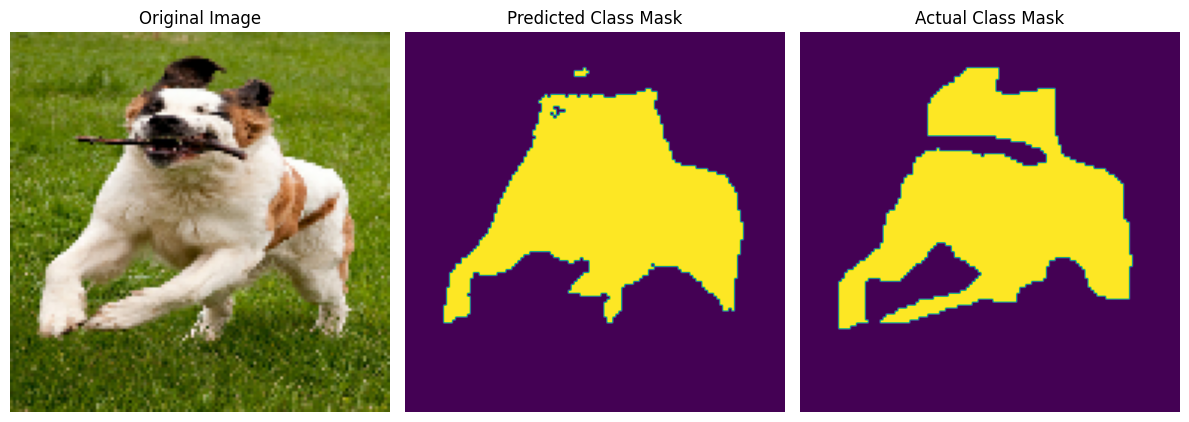

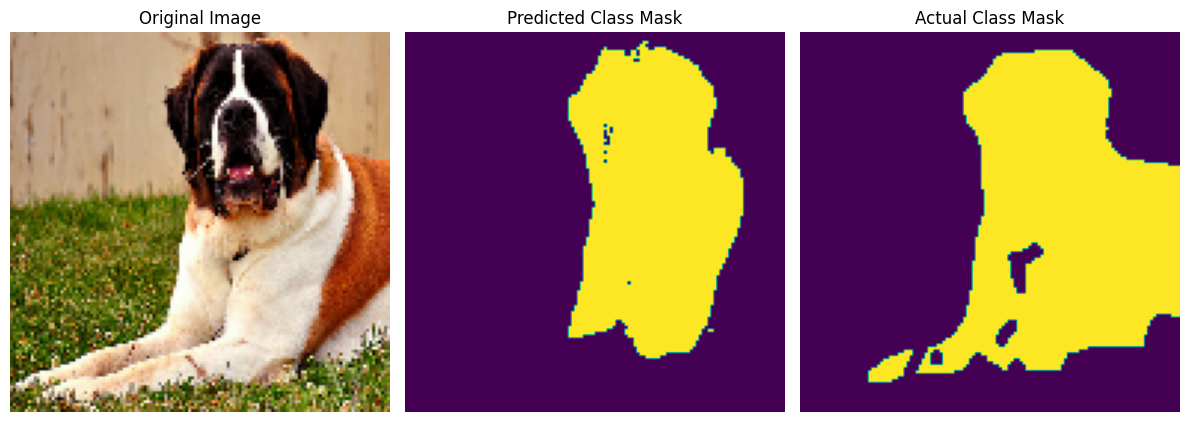

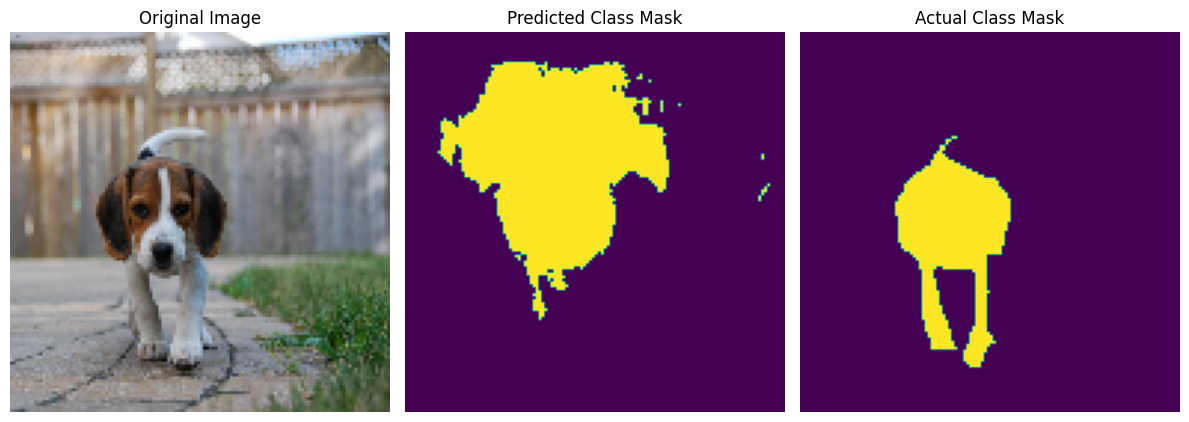

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def create_predicted_labels(model, sample_data):
    # Extract one batch of images and masks from the dataset
    for batch_images, batch_labels in sample_data.take(1):
        # Run predictions on the batch of images
        predictions = model.predict(batch_images)

        # Identify the most likely class for each pixel using argmax
        class_labels = np.argmax(predictions, axis=-1)

        # Expand the dimensions for compatibility with visualization functions
        class_labels = np.expand_dims(class_labels, axis=-1)

        return class_labels, batch_images, batch_labels

def show_segmentation_outputs(model, sample_data):
    # Obtain the predicted masks and original images
    pred_labels, original_images, actual_labels = create_predicted_labels(model, sample_data)

    # Loop through a limited number of samples (e.g., 5) for visualization
    for idx in range(5):
        plt.figure(figsize=(12, 5))

        # Display the original image
        plt.subplot(1, 3, 1)
        plt.imshow(original_images[idx].numpy().astype("uint8"))
        plt.axis('off')
        plt.title("Original Image")

        # Display the predicted multi-class mask
        plt.subplot(1, 3, 2)
        plt.imshow(pred_labels[idx, :, :, 0], cmap='viridis')
        plt.axis('off')
        plt.title("Predicted Class Mask")

        # Display the actual multi-class mask
        plt.subplot(1, 3, 3)
        plt.imshow(actual_labels[idx, :, :, 0], cmap='viridis')
        plt.axis('off')
        plt.title("Actual Class Mask")

        # Adjust layout and show the plot
        plt.tight_layout()
        plt.show()

# Call the function to visualize segmentation predictions on the test dataset
show_segmentation_outputs(unet_model, test_dataset)